In [ ]:
import torch
from torch import nn

from skimage import data

## Pooling

Documentação: https://pytorch.org/docs/stable/nn.html#torch.nn.MaxPool2d

```python
torch.nn.MaxPool2d(kernel_size, stride=None, padding=0)
```

**```kernel_size```** <br>
Tamanho dos *Field of View*. Pode ser uma tupla ou um único número. Ex: ```kernel_size = 3``` definirá FoV de $3 \times 3$

**```stride```** <br>
Controla o pulo da janela deslizante. 

**```padding```** <br>
Preenchimento com zeros nas bordas da imagem.

A camda de pooling espera uma entrada de **pelo menos** 3 dimensões ($C \times H \times W$), mas em geral a rede irá prover também a dimensão do batch ($B \times C \times H \times W$) 

In [ ]:
tns = torch.FloatTensor([ [ [ 1, 2,3 ], 
                            [4,5,6], 
                            [7,8,9]  ] ] )

pool = nn.MaxPool2d(2, stride=1)
saida = pool(tns)

print(tns.size()) #torch.Size([1, 3, 3]) 1 canaç com 3 altura e 3 de largura
print(tns)
print(saida.size())
print(saida)

torch.Size([1, 3, 3])
tensor([[[1., 2., 3.],
         [4., 5., 6.],
         [7., 8., 9.]]])
torch.Size([1, 2, 2])
tensor([[[5., 6.],
         [8., 9.]]])


Ao processar dados com múltiplos canais, a camada de pooling processa cada canal de entrada separadamente ao invés de processar todos os canais como em uma camada convolucional. Isso significa que **o número de canais de saída para a camada de pooling é o mesmo que o número de canais de entrada**. 

Vamos processar abaixo a imagem da astronauta.

In [ ]:
conv = nn.Conv2d(in_channels=3, out_channels=16, 
                 kernel_size=3, padding=1)

rgb = data.astronaut()
rgb_tns = torch.Tensor(rgb)
rgb_tns = rgb_tns.permute(2, 0, 1).unsqueeze(0)
mapa_de_ativacao = conv(rgb_tns)
print('Feature Map:', mapa_de_ativacao.shape)

Feature Map: torch.Size([1, 16, 512, 512])


In [ ]:
pool = nn.MaxPool2d(kernel_size=2) #stride == kernel
saida = pool(mapa_de_ativacao)
print(saida.size())

torch.Size([1, 16, 256, 256])


**Exercicio**

O papel do Pooling é subamostrar o mapa de ativação produzido pela convolução, a partir de um processo que destaca as principais características daquele mapa. A redução das dimensões espaciais é definida de acordo com o campo de visão e o stride do Pooling. Por exemplo, a camada nn.MaxPool2d(kernel_size=2, stride=2) reduzirá as dimensões espaciais pela metade, pois cada janela 2 x 2 da entrada será resumida em um único valor.

A partir do bloco convolucional a seguir, qual é o tamanho mínimo da entrada, capaz de produzir uma saída de dimensões válidas iguais a 2 x 1 x 1?

In [ ]:
ConvolutionBlock = nn.Sequential(nn.Conv2d(3, 16, kernel_size=3, padding=1),
                                 nn.BatchNorm2d(16),
                                 nn.ReLU(),
                                 nn.MaxPool2d(kernel_size=5, stride=5),
                                 nn.Conv2d(16, 2, kernel_size=3, padding=1), 
                                 nn.BatchNorm2d(2),
                                 nn.ReLU(),
                                 nn.MaxPool2d(kernel_size=5, stride=5),
                                 )

Dica: as camadas convolucionais foram projetadas para não alterar as dimensões espaciais da entrada. A subamostragem é realizada exclusivamente pelo Pooling.

In [ ]:
ConvolutionBlock

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(16, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): MaxPool2d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
)

In [ ]:
## (3 X 25 X 25)
"""O kernel de tamanho 5 x 5 e stride 5 divide por 5 as dimensões espaciais da entrada. 
Uma sequência de duas camadas com essas configurações reduzirão 25 x 25 para 5 x 5 e então para 1 x 1."""

'O kernel de tamanho 5 x 5 e stride 5 divide por 5 as dimensões espaciais da entrada. \nUma sequência de duas camadas com essas configurações reduzirão 25 x 25 para 5 x 5 e então para 1 x 1.'

Enumeramos em aula algumas vantagens da subamostragem em redes convolucionais. Em termos de custo computacional, reduzir a dimensionalidade espacial dos mapas de ativação permite uma grande economia de processamento. Por si só essa já é uma vantagem bastante convincente para usar o pooling, pois imagens são dados de altíssima dimensionalidade.

Um dos principais livros de Deep Learning [1] define o Pooling como um "resumo estatístico" das saídas de uma convolução. Isso porque a camada não realiza uma subamostragem aleatória dos mapas de ativação, mas destaca as características mais relevantes de cada vizinhança local (definida pelo campo de visão do pooling).

Um importante efeito disso é que o Pooling torna a representação aproximadamente invariante a pequenas translações. Em termos claros, se a imagem de entrada for levemente deslocada no espaço, uma boa parte do mapa de características resultante do pooling não será alterado. A imagem a seguir mostra exemplos do mesmo objeto após translações no espaço.

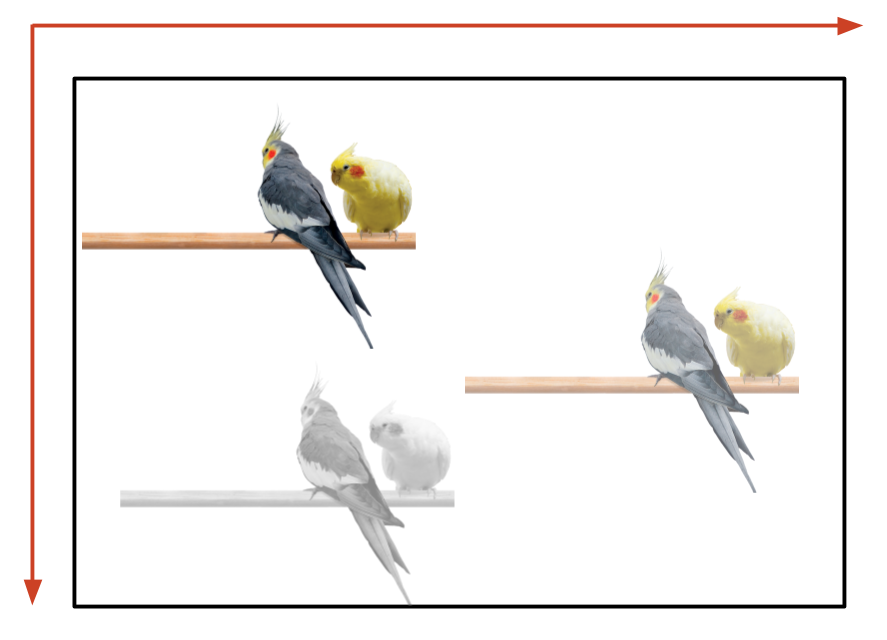

Os mapas de ativação produzidos pela convolução mantêm a informação espacial da entrada, ou seja, a localização das características ativadas está fortemente relacionada à localização das regiões correspondentes. Uma imagem espacialmente deslocada terá como saída um mapa de ativação espacialmente deslocado. Com o Pooling e o seu resumo estatístico, a rede concentra seus esforços em identificar a presença de características relevantes, independentes da sua localização específica na imagem.

Vale ressaltar que a informação espacial da imagem ainda é mantida até certo nível. O exemplo dado pelo livro menciona o problema de detecção de faces. Não importa a localização precisa dos olhos, mas importa bastante saber que existe um olho do lado esquerdo da face e outro do lado direito. O Pooling preserva esse nível de informação, que para a maioria dos problemas não só é suficiente, como também é vantajoso pela adição da invariância.

[1] Goodfellow, Ian, Yoshua Bengio, and Aaron Courville. Deep learning. MIT press, 2016, pg 342.



## Batch Normalization

Documentação: https://pytorch.org/docs/stable/nn.html#torch.nn.BatchNorm2d

```python
torch.nn.BatchNorm2d(num_features)
```

**```num_features```**<br>
$\mathbf{\gamma}$ e $\mathbf{\beta}$ são aprendidos individualmente para cada canal da entrada. Em ativações de camadas intermediárias, esse valor corresponde ao **número de feature maps**. 


Normalização == pré-processamento (convergencia mais estável) == (espaço de busca mais controlado)

Sempre normalizar seus dados antes de fazer a rede neural.

**Uma camada adcicionada apos a convolução e antes da ativação linear para realizar operações a medida que a imagem passa na rede**

[ Conv -> batch norm -> ReLU ]



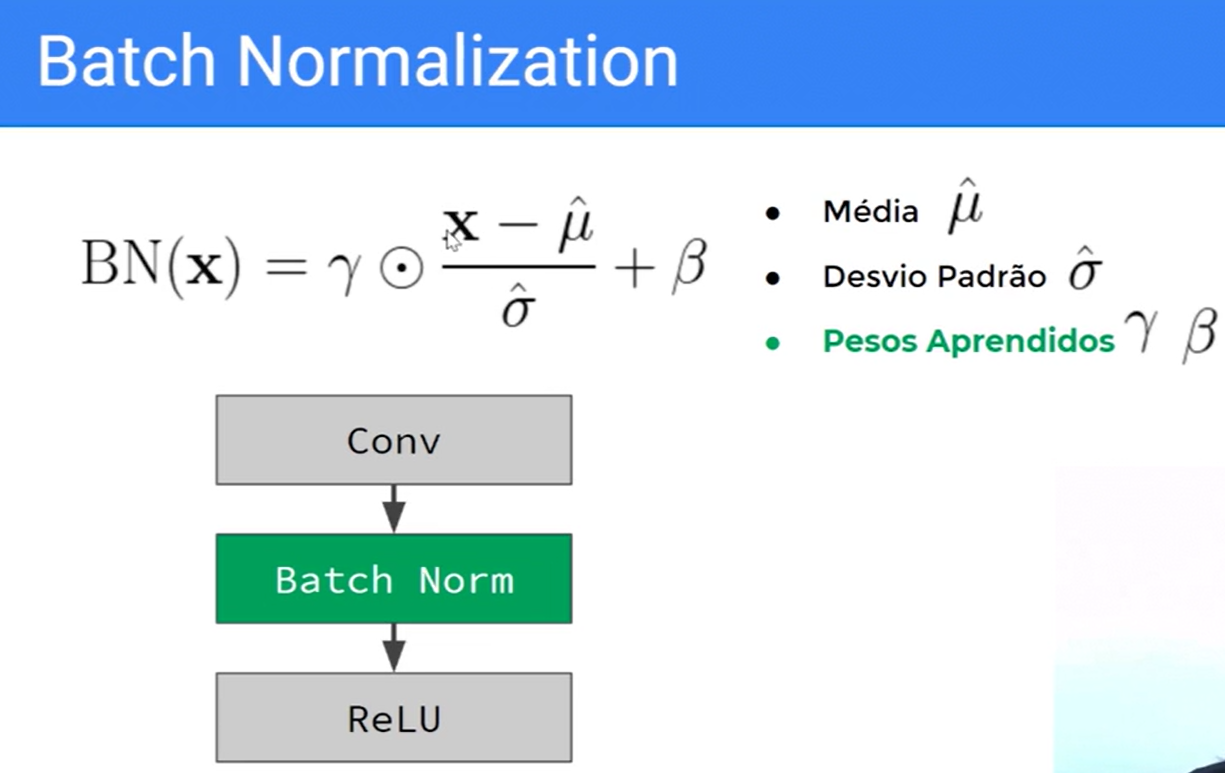

batch norm -> precisa reinstanciar sempre! diferente da ReLU



In [ ]:
## imagem da astronauta
blococonv = nn.Sequential(
                nn.Conv2d(3, 32, kernel_size=3, padding=1),                     # nao perde resolução com padding ==1
                nn.BatchNorm2d(32),                                             # 32 canais para normalizar, nao muda a dimensionalidade
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=10)                                    # stride de mesmo tamanho ==10 -> reduz a resolução espacial da imagem em 10x
                )

print(blococonv)

minibatch = torch.cat(12*[rgb_tns])                                             # concatenando varias vezes o mesmo tensor para aumentar a qtde de imagens

print(minibatch.size())
saida = blococonv(minibatch)
print(saida.size())

#Sequential é um objeto tipo container

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=10, stride=10, padding=0, dilation=1, ceil_mode=False)
)
torch.Size([12, 3, 512, 512])
torch.Size([12, 32, 51, 51])


A biblioteca do PyTorch implementa as principais funções de Pooling utilizadas em redes neurais. Explore a documentação e substitua o pooling utilizado no script Outras_Camadas.ipynb por outras funções 2D, como o AvgPool2d ou o AdaptiveMaxPool2d. Note que esse último não leva como parâmetro o tamanho do kernel, mas sim o tamanho da saída desejada.

A alteração deve ser feita na célula que define o Pooling na variável pool

Dica: ao usar Poolings adaptativos (AdaptiveMaxPool2d), varie o tamanho da entrada e analise o efeito disso na saída.

Para realizar a substituição da função de Pooling, basta trocar o nome MaxPool2d pela função do seu interesse, dentre as listadas na documentação. Por exemplo:

pool = nn.AdaptiveMaxPool2d(output_size=(7,7))

Note que o pooling adaptativo permite que, independentemente do tamanho da entrada, a saída esteja de acordo com o tamanho definido na função. É preciso tomar cuidado ao usar esse Pooling, pois se o tamanho da entrada for muito maior que a saída desejada haverá grande perda de informação.

In [ ]:
## imagem da astronauta
blococonv = nn.Sequential(
                nn.Conv2d(3, 32, kernel_size=3, padding=1),                     # nao perde resolução com padding ==1
                nn.BatchNorm2d(32),                                             # 32 canais para normalizar, nao muda a dimensionalidade
                nn.ReLU(),
                nn.AdaptiveMaxPool2d(output_size=(7,7))                                    # stride de mesmo tamanho ==10 -> reduz a resolução espacial da imagem em 10x
                )

print(blococonv)

minibatch = torch.cat(12*[rgb_tns])                                             # concatenando varias vezes o mesmo tensor para aumentar a qtde de imagens

print(minibatch.size())
saida = blococonv(minibatch)
print(saida.size())

#Sequential é um objeto tipo container

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): AdaptiveMaxPool2d(output_size=(7, 7))
)
torch.Size([12, 3, 512, 512])
torch.Size([12, 32, 7, 7])
